In [ ]:

!git clone https://github.com/dmj6288/ESM_ProteinPred.git


Cloning into 'ESM_ProteinPred'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 636.38 KiB | 11.16 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
!cd /content/ESM_ProteinPred/

In [ ]:

!pip install --upgrade git+https://github.com/sokrypton/esm.git


  Cloning https://github.com/sokrypton/esm.git to /tmp/pip-req-build-vq40lfmp
  Running command git clone --filter=blob:none --quiet https://github.com/sokrypton/esm.git /tmp/pip-req-build-vq40lfmp
  Resolved https://github.com/sokrypton/esm.git to commit f6ef2277cd3e2b75ff4e4c8a8efa7457671ddb33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip3 install torch torchaudio torchvision torchtext torchdata
# ESM isn't on pip/conda by default — clone from source
!pip install fair-esm
!pip install umap-learn biopython pandas scikit-learn matplotlib
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # PyTorch with CUDA 11.8


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
# Protein Embedding Project Skeleton
# Requirements: esm, pandas, scikit-learn, matplotlib, umap-learn

import torch
import esm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import umap
import numpy as np
import requests
import seaborn as sns
from Bio import SeqIO
from io import StringIO
from scipy.cluster.hierarchy import linkage, dendrogram


In [ ]:
# === 1. Load lightweight ESM model ===
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()  # Smallest model
batch_converter = alphabet.get_batch_converter()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [ ]:

import requests
from Bio import SeqIO
from io import StringIO
from time import sleep

species_map = {
    "human": "homo_sapiens",
    "chimp": "pan_troglodytes",
    "macaque": "macaca_mulatta"
}

def get_ensembl_gene_id(gene_symbol, species="homo_sapiens"):
    url = f"https://rest.ensembl.org/xrefs/symbol/{species}/{gene_symbol}?"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    if response.ok and response.json():
        return response.json()[0]["id"]
    return None

def get_orthologs(human_gene_id, target_species):
    url = f"https://rest.ensembl.org/homology/id/human/{human_gene_id}?type=orthologues;format=full;content-type=application/json"
    response = requests.get(url)
    if not response.ok:
        return {}
    data = response.json()
    homologs = {}
    for homology in data["data"][0]["homologies"]:
        sp = homology["target"]["species"]
        if sp in target_species:
            homologs[sp] = homology["target"]["protein_id"]
    return homologs

def get_protein_sequence(protein_id, source="ensembl"):
    if source == "ensembl":
        url = f"https://rest.ensembl.org/sequence/id/{protein_id}?type=protein"
        headers = {"Content-Type": "text/x-fasta"}
    else:
        url = f"https://rest.uniprot.org/uniprotkb/{protein_id}.fasta"
        headers = {}
    response = requests.get(url, headers=headers)
    if not response.ok:
        return None
    fasta_io = StringIO(response.text)
    record = next(SeqIO.parse(fasta_io, "fasta"))
    return str(record.seq)

def get_uniprot_id(gene, species_taxid=9606):
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"gene_exact:{gene} AND organism_id:{species_taxid} AND reviewed:true",
        "fields": "accession",
        "format": "tsv",
        "size": 1
    }
    response = requests.get(url, params=params)
    if response.ok:
        lines = response.text.strip().split("\n")
        if len(lines) > 1:
            return lines[1].split("\t")[0]
    return None

# === MAIN LOOP FOR MARKER SET ===
genes = ['AQP4', 'SLC1A2', 'SLC4A4', 'GFAP', 'ALDH1L1', 'GJA1', 'GAD1', 'GAD2',
         'GRIK2', 'KCNC2', 'CDH9', 'KIT', 'SST', 'VIP', 'SV2C', 'SLC17A7', 'SATB2',
         'CAMK2A', 'CBLN2', 'IL1RAPL2', 'TRPM3', 'SEMA3E', 'SYT1', 'RBFOX3',
         'CUX2', 'RORB', 'TLE4', 'TYROBP', 'APBB1IP', 'P2RY12', 'CSF1R', 'CX3CR1',
         'PTPRC', 'DOCK8', 'HLA.DRA', 'OPALIN', 'MOBP', 'MBP', 'PLP1', 'ST18',
         'MOG', 'PDGFRA', 'PCDH15', 'VCAN', 'CSPG4']  # replace with your full marker list

species = ['human', 'chimp', 'macaque']

all_seqs = {gene: {} for gene in genes}
all_embeddings = {gene: {} for gene in genes}

MAX_LEN = 512

for gene in genes:
    print(f"\nProcessing {gene}...")

    # Step 1: Get human Ensembl gene ID
    human_gene_id = get_ensembl_gene_id(gene)
    if not human_gene_id:
        print(f"  ❌ Could not find Ensembl ID for {gene}")
        continue

    # Step 2: Get orthologs
    homologs = get_orthologs(human_gene_id, target_species=list(species_map.values())[1:])

    # Step 3: Get protein sequences and calculate embeddings
    for sp_key in species:
        seq = None
        seq_id = f"{gene}_{sp_key}"

        if sp_key == "human":
            uniprot_id = get_uniprot_id(gene)
            if uniprot_id:
                seq = get_protein_sequence(uniprot_id, source="uniprot")
        else:
            sp_name = species_map[sp_key]
            if sp_name in homologs:
                prot_id = homologs[sp_name]
                seq = get_protein_sequence(prot_id, source="ensembl")

        if seq:
            print(f"{gene} [{sp_key}] seq length: {len(seq)}")
            all_seqs[gene][sp_key] = seq
            if len(seq) > MAX_LEN:
                seq = seq[:MAX_LEN]

            # Compute ESM embedding
            batch_labels, batch_strs, batch_tokens = batch_converter([(seq_id, seq)])
            batch_tokens = batch_tokens.to(device)
            with torch.no_grad():
                results = model(batch_tokens, repr_layers=[6], return_contacts=False)
            token_representations = results["representations"][6]
            emb = token_representations[0, 1:len(seq)+1].mean(0)
            all_embeddings[gene][sp_key] = emb.cpu().numpy()
        else:
            print(f"  ⚠️ Sequence not found for {gene} [{sp_key}]")




Processing AQP4...
AQP4 [human] seq length: 323
AQP4 [chimp] seq length: 323
AQP4 [macaque] seq length: 348

Processing SLC1A2...
SLC1A2 [human] seq length: 574
SLC1A2 [chimp] seq length: 574
SLC1A2 [macaque] seq length: 611

Processing SLC4A4...
SLC4A4 [human] seq length: 1079
SLC4A4 [chimp] seq length: 1100
SLC4A4 [macaque] seq length: 1125

Processing GFAP...
GFAP [human] seq length: 432
GFAP [chimp] seq length: 505
GFAP [macaque] seq length: 462

Processing ALDH1L1...
ALDH1L1 [human] seq length: 902
ALDH1L1 [chimp] seq length: 902
ALDH1L1 [macaque] seq length: 922

Processing GJA1...
GJA1 [human] seq length: 382
GJA1 [chimp] seq length: 400
GJA1 [macaque] seq length: 382

Processing GAD1...
GAD1 [human] seq length: 594
GAD1 [chimp] seq length: 594
GAD1 [macaque] seq length: 594

Processing GAD2...
GAD2 [human] seq length: 585
GAD2 [chimp] seq length: 585
GAD2 [macaque] seq length: 608

Processing GRIK2...
GRIK2 [human] seq length: 908
GRIK2 [chimp] seq length: 908
GRIK2 [macaque] 

In [ ]:
from sklearn.metrics.pairwise import cosine_distances


In [ ]:
# === 3. Compare embeddings across species ===
def cosine_diff(a, b):
    return cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0][0]

diff_table = []
for gene in genes:
    row = {"Gene": gene}
    try:
        row["Human-Chimp"] = cosine_diff(all_embeddings[gene]["human"], all_embeddings[gene]["chimp"])
    except:
        row["Human-Chimp"] = None
    try:
        row["Human-Macaque"] = cosine_diff(all_embeddings[gene]["human"], all_embeddings[gene]["macaque"])
    except:
        row["Human-Macaque"] = None
    try:
        row["Chimp-Macaque"] = cosine_diff(all_embeddings[gene]["chimp"], all_embeddings[gene]["macaque"])
    except:
        row["Chimp-Macaque"] = None
    diff_table.append(row)


In [ ]:

# === 4. Display sorted divergence table ===
df_diff = pd.DataFrame(diff_table)
print("\nTop Divergent Genes (Human vs Chimp):")
print(df_diff.sort_values(by="Human-Chimp", ascending=False).head())




Top Divergent Genes (Human vs Chimp):
      Gene  Human-Chimp  Human-Macaque  Chimp-Macaque
37     MBP     0.159250       0.185625       0.007221
13     VIP     0.092811       0.090161       0.005651
27  TYROBP     0.025057       0.079973       0.046565
44   CSPG4     0.019216       0.002043       0.014738
36    MOBP     0.009287       0.009346       0.025447


In [ ]:
# === 4. Display sorted divergence table ===
df_diff = pd.DataFrame(diff_table)
print("\nTop Divergent Genes (Human vs Chimp):")
print(df_diff.sort_values(by="Human-Chimp", ascending=False).head())



Top Divergent Genes (Human vs Chimp):
      Gene  Human-Chimp  Human-Macaque  Chimp-Macaque
37     MBP     0.159250       0.185625       0.007221
13     VIP     0.092811       0.090161       0.005651
27  TYROBP     0.025057       0.079973       0.046565
44   CSPG4     0.019216       0.002043       0.014738
36    MOBP     0.009287       0.009346       0.025447


In [ ]:

all_considered_genes = genes[0:6] + genes[6:15] + genes[15:27] + genes[27:34] + genes[35:41] + genes[41:]
all_cell_types = ["Astro" for i in range(len(genes[0:6]))] + ["Inhibit" for i in range(len(genes[6:15]))] + ["Excite" for i in range(len(genes[15:27]))] + ["Micro" for i in range(len(genes[27:34]))] + ["Oligo" for i in range(len(genes[35:41]))] + ["OPC" for i in range(len(genes[41:]))]
all_symbols = ["o" for i in range(len(genes[0:6]))] + ["x" for i in range(len(genes[6:15]))] + ["*" for i in range(len(genes[15:27]))] + ["D" for i in range(len(genes[27:34]))] + ["+" for i in range(len(genes[35:41]))] + ["P" for i in range(len(genes[41:]))]


In [ ]:
marker_label_dict = dict(zip(all_considered_genes, all_symbols))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


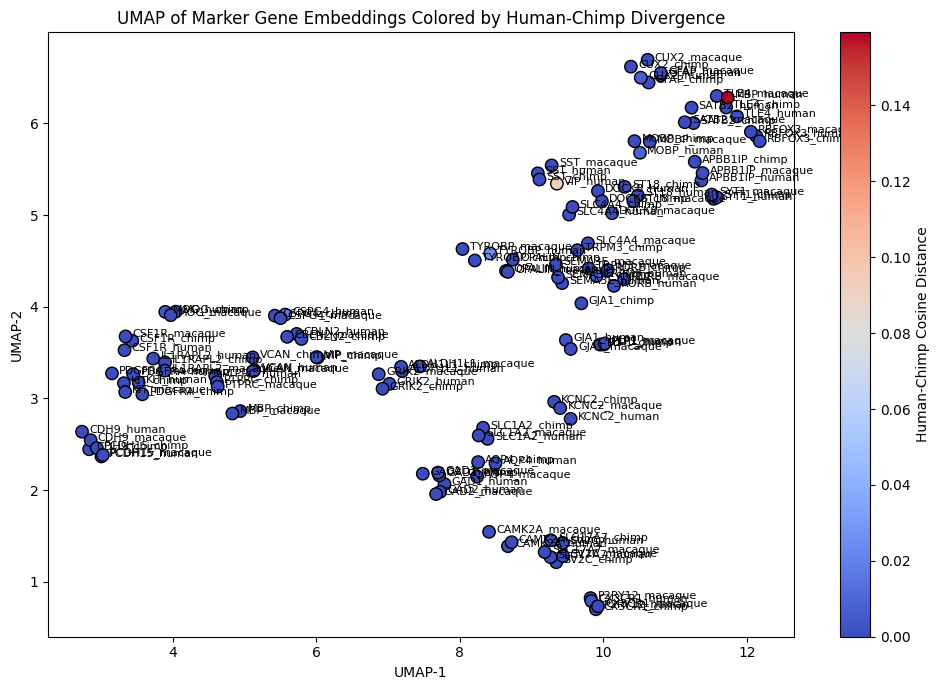

In [ ]:

# === 5. UMAP Visualization for all embeddings with divergence shading ===
combined_embeddings = []
combined_labels = []
cell_type_labels = []
combined_divergence = []

for gene, emb_dict in all_embeddings.items():
    for sp, emb in emb_dict.items():
        combined_embeddings.append(emb)
        combined_labels.append(f"{gene}_{sp}")
        # Assign divergence score only for human embeddings using Human-Chimp as default
        if sp == "human":
            score = df_diff.loc[df_diff["Gene"] == gene, "Human-Chimp"].values[0] if gene in df_diff["Gene"].values else None
        else:
            score = None
        cell_type_labels.append(marker_label_dict[gene])
        combined_divergence.append(score)

embedding_2d = umap.UMAP().fit_transform(np.stack(combined_embeddings))

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=[v if v is not None else 0 for v in combined_divergence],
    cmap="coolwarm", s=80, edgecolor='k')
plt.colorbar(scatter, label="Human-Chimp Cosine Distance")
for label, (x, y) in zip(combined_labels, embedding_2d):
    plt.text(x+0.1, y, label, fontsize=8)
plt.title("UMAP of Marker Gene Embeddings Colored by Human-Chimp Divergence")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()



In [66]:

subset_heatmap_df = heatmap_df.loc[['GFAP', 'VIP', 'TRPM3', 'RBFOX3', 'TLE4', 'MOG', 'MBP']]


In [70]:

heatmap_df.to_csv('heatmap_df.csv')

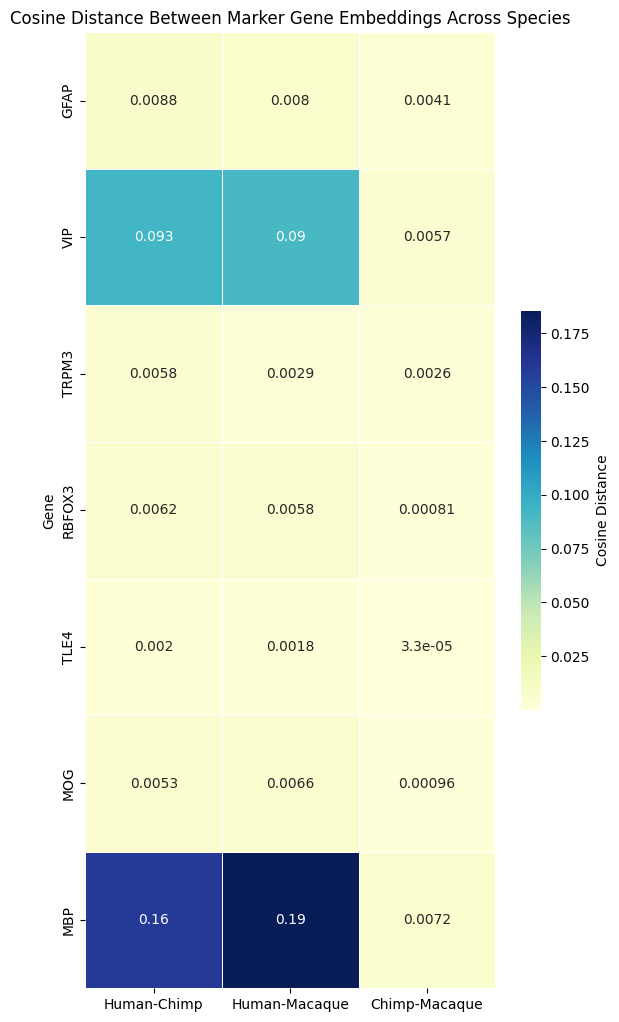

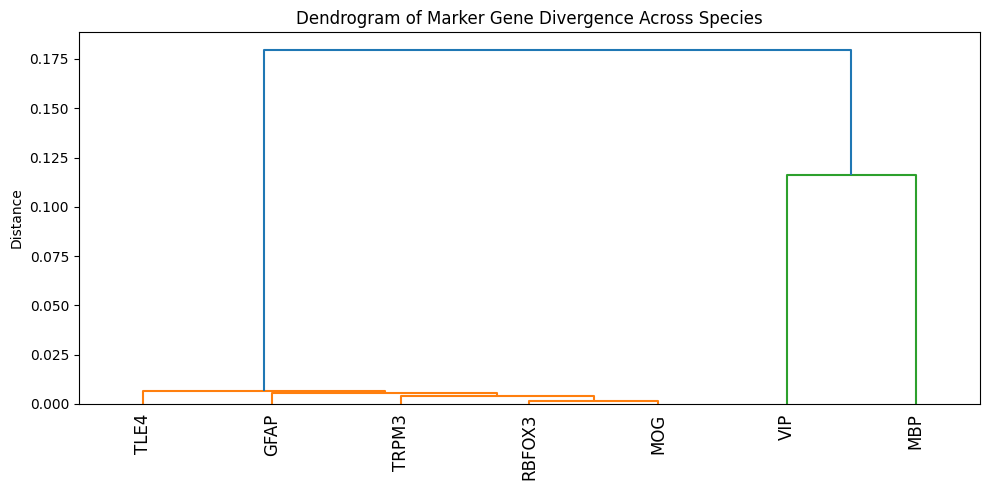

In [68]:

# === 6. Heatmap of Cosine Distances ===
heatmap_df = df_diff.set_index("Gene").dropna()
plt.figure(figsize=(6, len(heatmap_df) * 0.75))  # Adjust cell height
sns.heatmap(subset_heatmap_df, annot=True,  cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Cosine Distance', 'shrink': 0.125}, square=True)
plt.title("Cosine Distance Between Marker Gene Embeddings Across Species")
plt.tight_layout()
plt.show()

# === 7. Dendrogram for hierarchical clustering ===
linkage_matrix = linkage(subset_heatmap_df, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=subset_heatmap_df.index.tolist(), leaf_rotation=90)
plt.title("Dendrogram of Marker Gene Divergence Across Species")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()



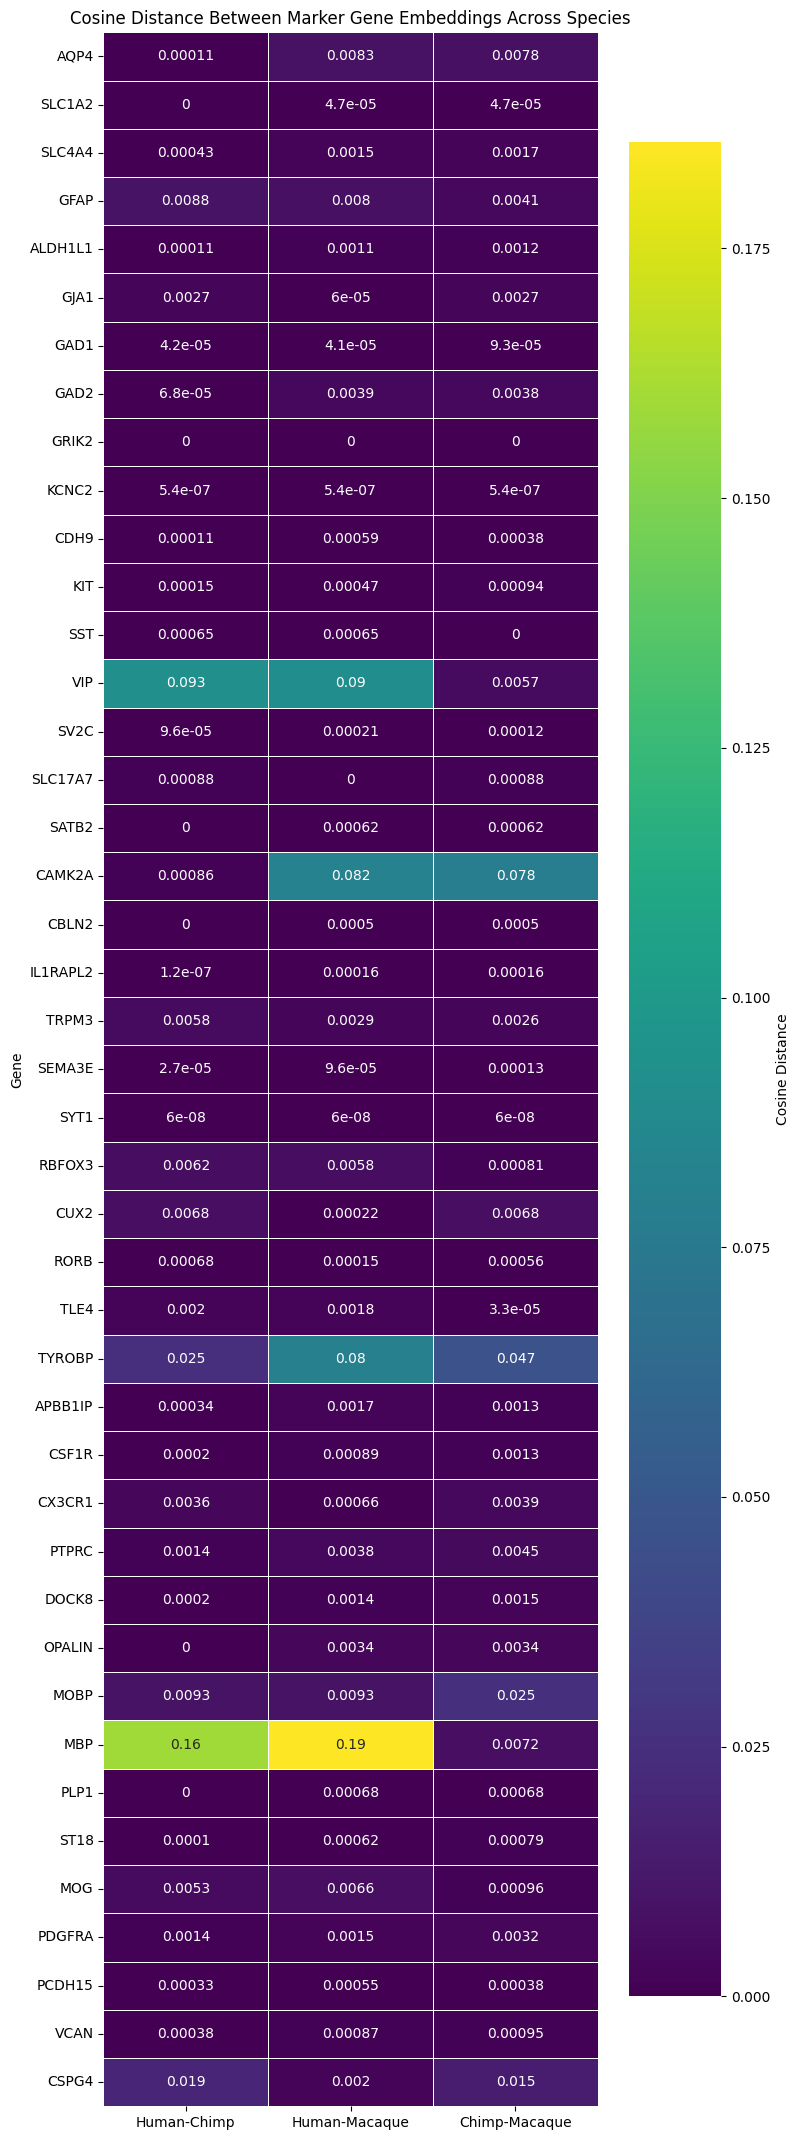

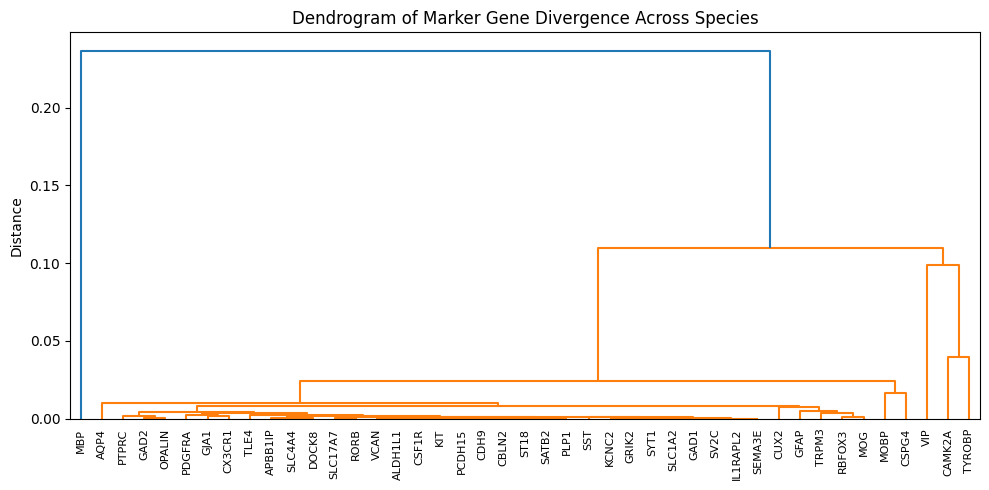

In [ ]:
# === 6. Heatmap of Cosine Distances ===
heatmap_df = df_diff.set_index("Gene").dropna()
plt.figure(figsize=(8, len(heatmap_df) * 0.5))  # Adjust cell height
sns.heatmap(heatmap_df, annot=True, cmap="viridis", linewidths=0.5, cbar_kws={'label': 'Cosine Distance'})
plt.title("Cosine Distance Between Marker Gene Embeddings Across Species")
plt.tight_layout()
plt.show()

# === 7. Dendrogram for hierarchical clustering ===
linkage_matrix = linkage(heatmap_df, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=heatmap_df.index.tolist(), leaf_rotation=90)
plt.title("Dendrogram of Marker Gene Divergence Across Species")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [ ]:

sequences = []

for gene, seq_dict in all_seqs.items():
    for sp, seq in seq_dict.items():
        sequences.append((gene + "_" + sp, seq))

In [ ]:

#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random
from sys import version_info

python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x, y):
  return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# Define your batch of sequences here
# Format: list of (jobname, sequence) tuples
sequence_tuple_list = sequences

# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
template_mode = "none" #@param ["none", "pdb100","custom"]
use_amber = num_relax > 0

for basejobname, query_sequence in sequence_tuple_list:
  query_sequence = "".join(query_sequence.split())
  basejobname = re.sub(r'\W+', '', basejobname)
  jobname = add_hash(basejobname, query_sequence)

  def check(folder):
    return not os.path.exists(folder)

  if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
      n += 1
    jobname = f"{jobname}_{n}"

  os.makedirs(jobname, exist_ok=True)

  # Save FASTA and CSV format for this job
  fasta_path = os.path.join(jobname, f"{jobname}.fasta")
  with open(fasta_path, "w") as f:
    f.write(f">{jobname}\n{query_sequence}")

  queries_path = os.path.join(jobname, f"{jobname}.csv")
  with open(queries_path, "w") as f:
    f.write(f"id,sequence\n{jobname},{query_sequence}\n")

  # Handle templates if needed
  if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
  elif template_mode == "custom":
    custom_template_path = os.path.join(jobname, "template")
    os.makedirs(custom_template_path, exist_ok=True)
    uploaded = files.upload()
    use_templates = True
    for fn in uploaded.keys():
      os.rename(fn, os.path.join(custom_template_path, fn))
  else:
    custom_template_path = None
    use_templates = False

  # Print status
  print(f"\nPrepared job: {jobname}")
  print("sequence:", query_sequence)
  print("length:", len(query_sequence.replace(":", "")))




Prepared job: AQP4_human_7a696
sequence: MSDRPTARRWGKCGPLCTRENIMVAFKGVWTQAFWKAVTAEFLAMLIFVLLSLGSTINWGGTEKPLPVDMVLISLCFGLSIATMVQCFGHISGGHINPAVTVAMVCTRKISIAKSVFYIAAQCLGAIIGAGILYLVTPPSVVGGLGVTMVHGNLTAGHGLLVELIITFQLVFTIFASCDSKRTDVTGSIALAIGFSVAIGHLFAINYTGASMNPARSFGPAVIMGNWENHWIYWVGPIIGAVLAGGLYEYVFCPDVEFKRRFKEAFSKAAQQTKGSYMEVEDNRSQVETDDLILKPGVVHVIDVDRGEEKKGKDQSGEVLSSV
length: 323

Prepared job: AQP4_chimp_f2d8f
sequence: MSDRPTARRWGKCGPLCTRENIMVAFKGVWTQAFWKAVTAEFLAMLIFVLLSLGSTINWGGTEKPLPVDMVLISLCFGLSIATMVQCFGHISGGHINPAVTVAMVCTRKISIAKSVFYIAAQCLGAIIGAGILYLVTPPSVVGGLGVTMVHGNLTAGHGLLVELIITFQLVFTIFASCDSKRTDVTGSIALAIGFSVAIGHLFAINYTGASMNPARSFGPAVIMGNWENHWIYWVGPIIGAVLAGGLYEYVFCPDVEFKRRFKEAFSKAAQQTKGSYMEVEDNRSQVETDDLILKPGVVHVIDIDRGEEKKGKDQSGEVLSSV
length: 323

Prepared job: AQP4_macaque_07060
sequence: MSDRPTARRWGKCGPLCTRENIMVAFRGVWTQAFWKAVTAEFLAMLIFVLLSLGSTINWGGTEKPLPVDMVLISLCFGLSIATMVQCFGHISGGHINPAVTVAMVCTRKISIAKSVFYIAAQCLGAIIGAGILYLVTPPSVVGGLGVTMVHGNLTAGHGLLVELIITFQLVFTIFASCDSKRTDVTGSIALAIGFSVAIG

In [ ]:

#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")


installing colabfold...
CPU times: user 101 ms, sys: 14.5 ms, total: 116 ms
Wall time: 32.2 s


In [ ]:


#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)




In [ ]:



#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.


In [ ]:

sequence_tuple_list_modified_indices = np.where([sequence_tuple_list[i][0].split("_")[0] in ['MBP'] for i in range(len(sequence_tuple_list))])[0].tolist()


In [ ]:

sequence_tuple_list_modified = [sequence_tuple_list[i] for i in sequence_tuple_list_modified_indices]


In [ ]:

sequence_tuple_list_modified


[('MBP_human',
  'MGNHAGKRELNAEKASTNSETNRGESEKKRNLGELSRTTSEDNEVFGEADANQNNGTSSQDTAVTDSKRTADPKNAWQDAHPADPGSRPHLIRLFSRDAPGREDNTFKDRPSESDELQTIQEDSAATSESLDVMASQKRPSQRHGSKYLATASTMDHARHGFLPRHRDTGILDSIGRFFGGDRGAPKRGSGKDSHHPARTAHYGSLPQKSHGRTQDENPVVHFFKNIVTPRTPPPSQGKGRGLSLSRFSWGAEGQRPGFGYGGRASDYKSAHKGFKGVDAQGTLSKIFKLGGRDSRSGSPMARR'),
 ('MBP_chimp',
  'MSLFPSLPLLLLSMVAASYSETVTCEDAQKTCPAVIACSSPGINGFPGKDGRDGTKGEKGEPGQGLRGLQGPPGKLGPPGNPGPSGSPGPKGQKGDPGKSPDGDSSLAASERKALQTEMARIKKWLTFSLGKQVGNKFFLTNGEIMTFEKVKALCVKFQASVATPRNAAENGAVRNLIKEEAFLGITDEKTEGQFVDLTGNRLTYTNWNEGEPNNAGSDEDCVLLLKNGQWNDVPCSTSHLAVSLILQESMIMEGNRTFASNRQSFGRPL'),
 ('MBP_macaque',
  'MALEGRTMSLFLSLTLLLLSVVATSYSETVTCEDSQKICPAVIACNSPGINGFPGKDGRDGTKGEKGEPGQGLRGLQGPPGKLGPPGNPGSSGSPGPKGQKGDPGESPDCESSLAASERKALQTEMARIKKWLTFSLGRQVGNKFFLTNGEMMTFDKVKALCAEFQASVATPRNAAENRAIQNLIKEEAFLGITDENTEGEFVDLTGNKLTYTNWNDGEPNNAGSNEDCVLLLKNGKWNDIPCSSSHLALCEFPI')]

2025-04-02 21:23:51,415 Running on GPU
2025-04-02 21:23:51,672 Found 5 citations for tools or databases
2025-04-02 21:23:51,672 Query 1/1: MBP_human_79b0c_0 (length 304)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


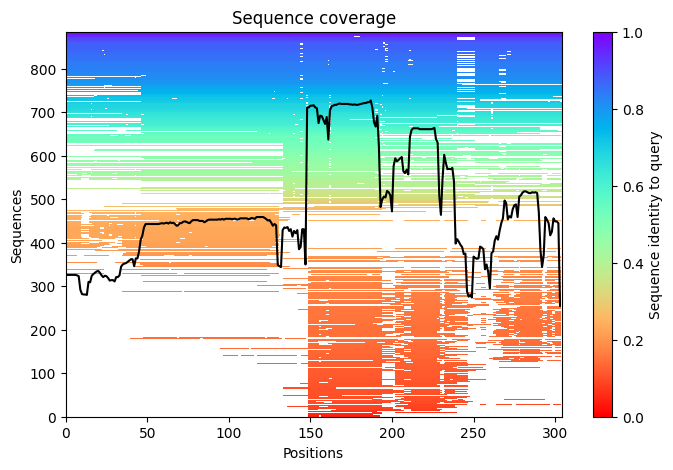

2025-04-02 21:23:54,021 Setting max_seq=512, max_extra_seq=373
2025-04-02 21:25:11,548 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=51.1 pTM=0.178
2025-04-02 21:25:14,153 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=50.8 pTM=0.208 tol=11.2
2025-04-02 21:25:16,717 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=51.1 pTM=0.223 tol=11.4
2025-04-02 21:25:19,290 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=50.9 pTM=0.235 tol=6.59
2025-04-02 21:25:19,370 alphafold2_ptm_model_1_seed_000 took 71.9s (3 recycles)


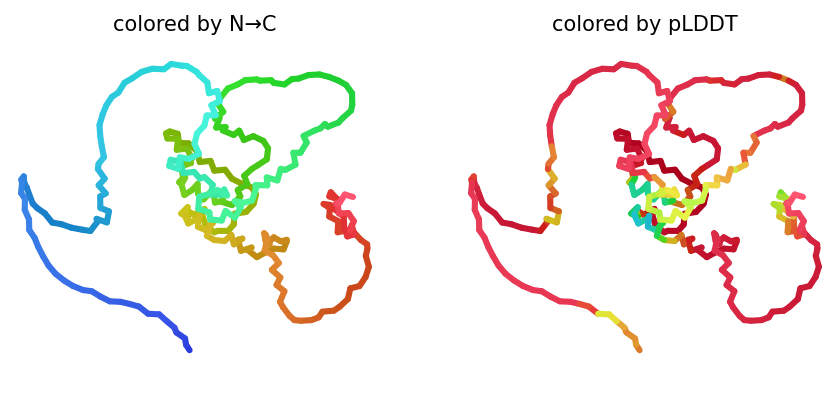

2025-04-02 21:25:22,188 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=49.8 pTM=0.163
2025-04-02 21:25:24,796 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=50.2 pTM=0.188 tol=15.1
2025-04-02 21:25:27,379 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=50.5 pTM=0.205 tol=7.62
2025-04-02 21:25:29,980 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=50.4 pTM=0.209 tol=3.15
2025-04-02 21:25:30,060 alphafold2_ptm_model_2_seed_000 took 10.4s (3 recycles)


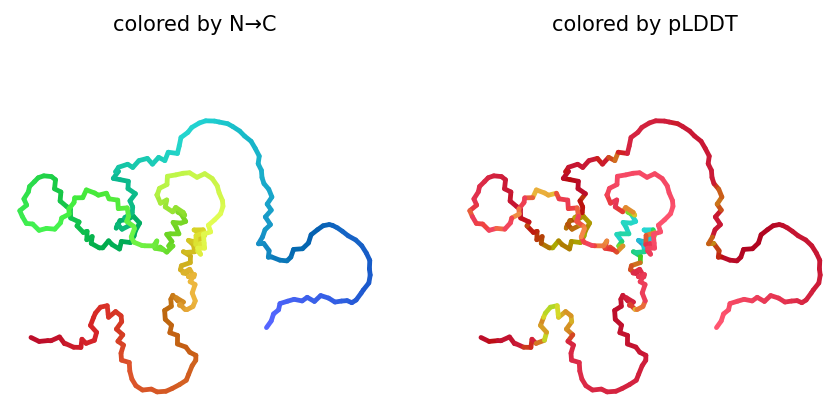

2025-04-02 21:25:32,843 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=50.1 pTM=0.162
2025-04-02 21:25:35,459 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=49.5 pTM=0.173 tol=16
2025-04-02 21:25:38,026 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=50 pTM=0.182 tol=4.97
2025-04-02 21:25:40,592 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=49.7 pTM=0.184 tol=4.98
2025-04-02 21:25:40,664 alphafold2_ptm_model_3_seed_000 took 10.3s (3 recycles)


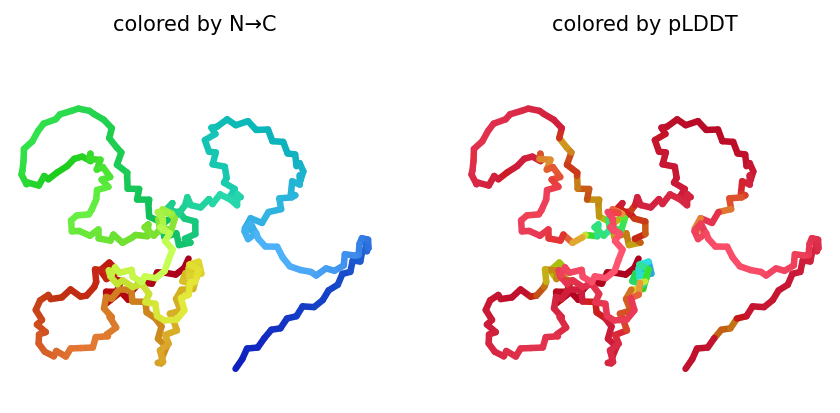

2025-04-02 21:25:43,480 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=48.6 pTM=0.167
2025-04-02 21:25:46,098 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=49.2 pTM=0.171 tol=14.4
2025-04-02 21:25:48,675 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=50.1 pTM=0.172 tol=5.53
2025-04-02 21:25:51,244 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=50.2 pTM=0.174 tol=4.41
2025-04-02 21:25:51,313 alphafold2_ptm_model_4_seed_000 took 10.3s (3 recycles)


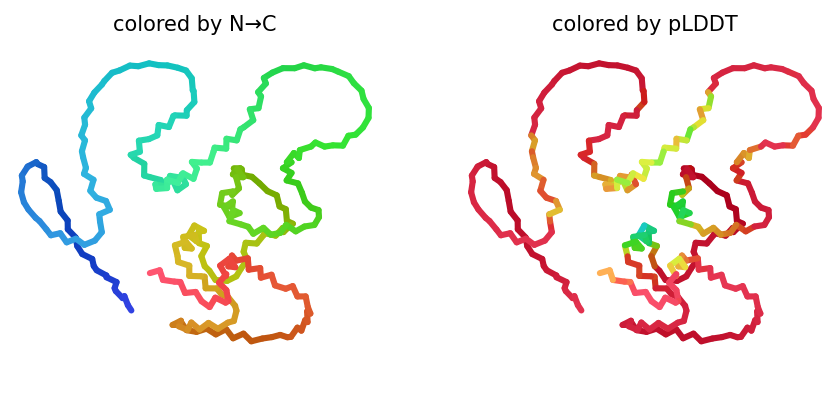

2025-04-02 21:25:54,113 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=45.6 pTM=0.141
2025-04-02 21:25:56,739 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=46.3 pTM=0.144 tol=13.7
2025-04-02 21:25:59,321 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=47.2 pTM=0.149 tol=7.59
2025-04-02 21:26:01,897 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=46.9 pTM=0.151 tol=5.42
2025-04-02 21:26:01,966 alphafold2_ptm_model_5_seed_000 took 10.4s (3 recycles)


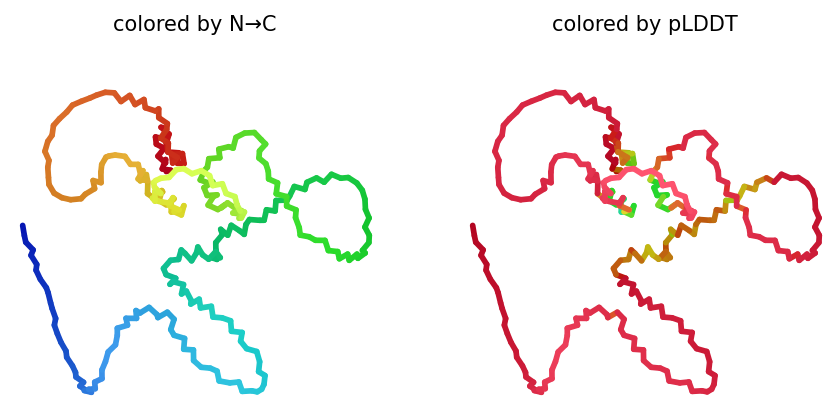

2025-04-02 21:26:02,248 reranking models by 'plddt' metric
2025-04-02 21:26:02,248 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=50.9 pTM=0.235
2025-04-02 21:26:02,249 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=50.4 pTM=0.209
2025-04-02 21:26:02,249 rank_003_alphafold2_ptm_model_4_seed_000 pLDDT=50.2 pTM=0.174
2025-04-02 21:26:02,249 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=49.7 pTM=0.184
2025-04-02 21:26:02,250 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=46.9 pTM=0.151
2025-04-02 21:26:06,966 Done
✅ Finished: MBP_human_79b0c_0
2025-04-02 21:26:12,425 Running on GPU
2025-04-02 21:26:12,428 Found 5 citations for tools or databases
2025-04-02 21:26:12,429 Query 1/1: MBP_chimp_bd66c_0 (length 270)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-04-02 21:26:13,125 Sleeping for 8s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:09 remaining: ?]

2025-04-02 21:26:21,809 Sleeping for 5s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:15 remaining: ?]

2025-04-02 21:26:27,505 Sleeping for 9s. Reason: PENDING


RUNNING:   6%|▌         | 9/150 [elapsed: 00:24 remaining: 06:27]

2025-04-02 21:26:37,183 Sleeping for 10s. Reason: RUNNING


RUNNING:  13%|█▎        | 19/150 [elapsed: 00:35 remaining: 03:45]

2025-04-02 21:26:47,878 Sleeping for 9s. Reason: RUNNING


RUNNING:  19%|█▊        | 28/150 [elapsed: 00:45 remaining: 02:55]

2025-04-02 21:26:57,567 Sleeping for 10s. Reason: RUNNING


RUNNING:  25%|██▌       | 38/150 [elapsed: 00:55 remaining: 02:23]

2025-04-02 21:27:08,250 Sleeping for 10s. Reason: RUNNING


RUNNING:  32%|███▏      | 48/150 [elapsed: 01:06 remaining: 02:02]

2025-04-02 21:27:18,936 Sleeping for 5s. Reason: RUNNING


RUNNING:  35%|███▌      | 53/150 [elapsed: 01:12 remaining: 01:55]

2025-04-02 21:27:24,623 Sleeping for 6s. Reason: RUNNING


RUNNING:  39%|███▉      | 59/150 [elapsed: 01:18 remaining: 01:46]

2025-04-02 21:27:31,306 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:29 remaining: 00:00]


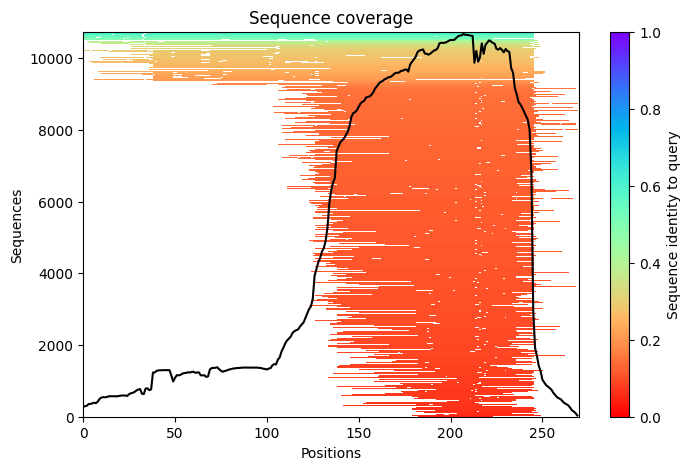

2025-04-02 21:27:43,871 Setting max_seq=512, max_extra_seq=5120
2025-04-02 21:29:00,670 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.1 pTM=0.476
2025-04-02 21:29:03,593 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=68.1 pTM=0.498 tol=10.9
2025-04-02 21:29:06,500 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=69.4 pTM=0.521 tol=5.74
2025-04-02 21:29:09,415 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=69.4 pTM=0.527 tol=4.36
2025-04-02 21:29:09,481 alphafold2_ptm_model_1_seed_000 took 78.7s (3 recycles)


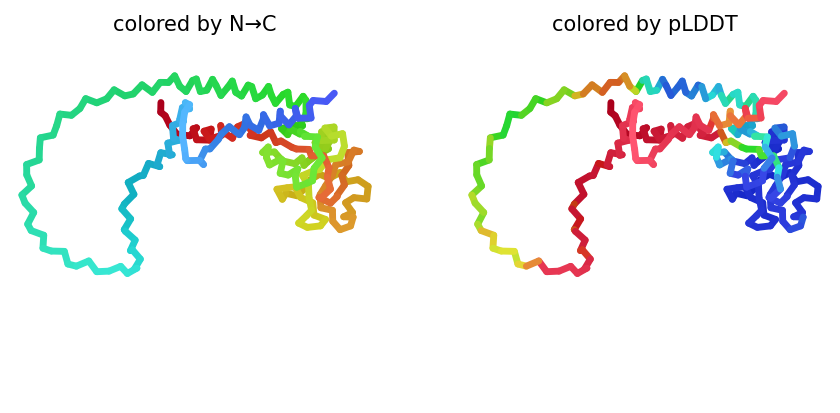

2025-04-02 21:29:12,581 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=68.6 pTM=0.457
2025-04-02 21:29:15,505 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=70.2 pTM=0.504 tol=10.8
2025-04-02 21:29:18,419 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=71.9 pTM=0.521 tol=4.68
2025-04-02 21:29:21,328 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=72.1 pTM=0.524 tol=1.98
2025-04-02 21:29:21,390 alphafold2_ptm_model_2_seed_000 took 11.7s (3 recycles)


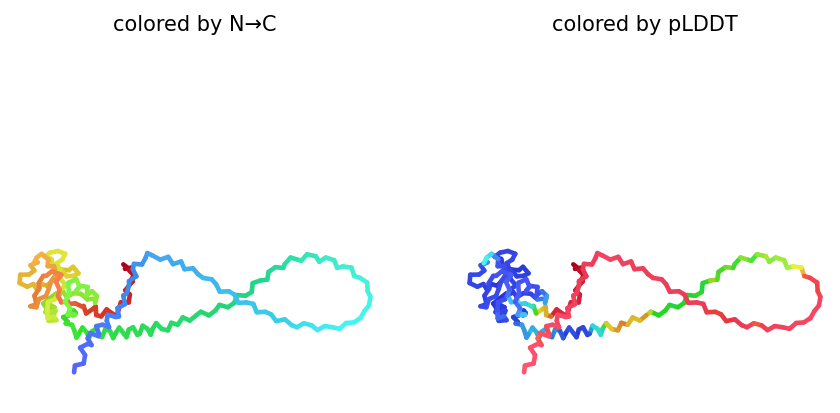

2025-04-02 21:29:24,489 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=71.4 pTM=0.497
2025-04-02 21:29:27,422 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=71.6 pTM=0.522 tol=7.52
2025-04-02 21:29:30,351 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=72.6 pTM=0.535 tol=3.25
2025-04-02 21:29:33,268 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=73.2 pTM=0.54 tol=1.63
2025-04-02 21:29:33,338 alphafold2_ptm_model_3_seed_000 took 11.7s (3 recycles)


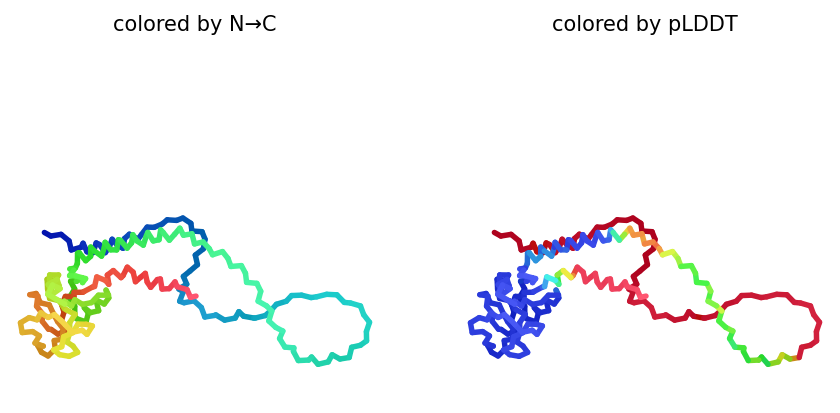

2025-04-02 21:29:36,473 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=72.8 pTM=0.549
2025-04-02 21:29:39,423 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=72.9 pTM=0.573 tol=8.96
2025-04-02 21:29:42,364 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=73 pTM=0.571 tol=3.53
2025-04-02 21:29:45,293 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=73.4 pTM=0.574 tol=3.71
2025-04-02 21:29:45,363 alphafold2_ptm_model_4_seed_000 took 11.8s (3 recycles)


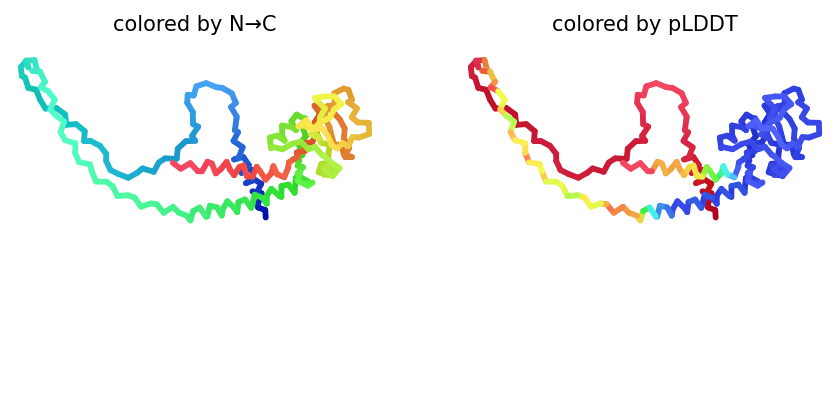

2025-04-02 21:29:48,469 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=70.4 pTM=0.515
2025-04-02 21:29:51,404 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=68.6 pTM=0.513 tol=3.33
2025-04-02 21:29:54,327 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=68.1 pTM=0.507 tol=2.12
2025-04-02 21:29:57,260 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=69.2 pTM=0.519 tol=3.39
2025-04-02 21:29:57,335 alphafold2_ptm_model_5_seed_000 took 11.7s (3 recycles)


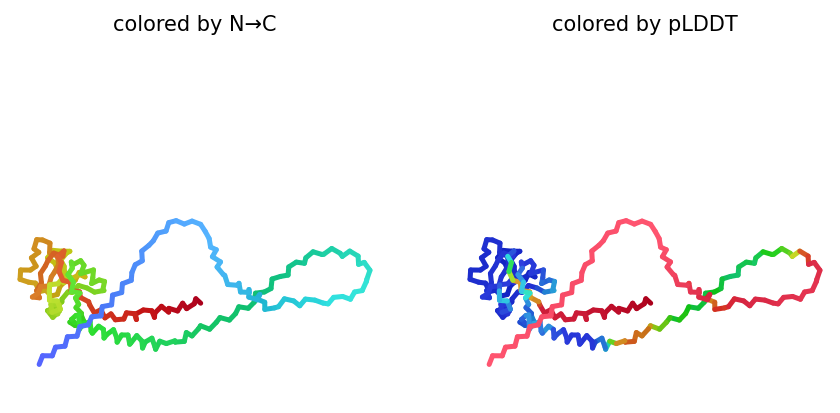

2025-04-02 21:29:57,569 reranking models by 'plddt' metric
2025-04-02 21:29:57,570 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=73.4 pTM=0.574
2025-04-02 21:29:57,570 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=73.2 pTM=0.54
2025-04-02 21:29:57,571 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=72.1 pTM=0.524
2025-04-02 21:29:57,571 rank_004_alphafold2_ptm_model_1_seed_000 pLDDT=69.4 pTM=0.527
2025-04-02 21:29:57,571 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=69.2 pTM=0.519
2025-04-02 21:30:01,586 Done
✅ Finished: MBP_chimp_bd66c_0
2025-04-02 21:30:06,185 Running on GPU
2025-04-02 21:30:06,189 Found 5 citations for tools or databases
2025-04-02 21:30:06,189 Query 1/1: MBP_macaque_66743_0 (length 255)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-04-02 21:30:06,884 Sleeping for 7s. Reason: PENDING


RUNNING:   5%|▍         | 7/150 [elapsed: 00:08 remaining: 02:51]

2025-04-02 21:30:14,581 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█         | 16/150 [elapsed: 00:18 remaining: 02:29]

2025-04-02 21:30:24,257 Sleeping for 7s. Reason: RUNNING


RUNNING:  15%|█▌        | 23/150 [elapsed: 00:25 remaining: 02:21]

2025-04-02 21:30:31,951 Sleeping for 6s. Reason: RUNNING


RUNNING:  19%|█▉        | 29/150 [elapsed: 00:32 remaining: 02:14]

2025-04-02 21:30:38,636 Sleeping for 9s. Reason: RUNNING


RUNNING:  25%|██▌       | 38/150 [elapsed: 00:42 remaining: 02:02]

2025-04-02 21:30:48,320 Sleeping for 5s. Reason: RUNNING


RUNNING:  29%|██▊       | 43/150 [elapsed: 00:47 remaining: 01:58]

2025-04-02 21:30:54,016 Sleeping for 10s. Reason: RUNNING


RUNNING:  35%|███▌      | 53/150 [elapsed: 00:58 remaining: 01:46]

2025-04-02 21:31:04,747 Sleeping for 9s. Reason: RUNNING


RUNNING:  41%|████▏     | 62/150 [elapsed: 01:08 remaining: 01:35]

2025-04-02 21:31:14,435 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:15 remaining: 00:00]


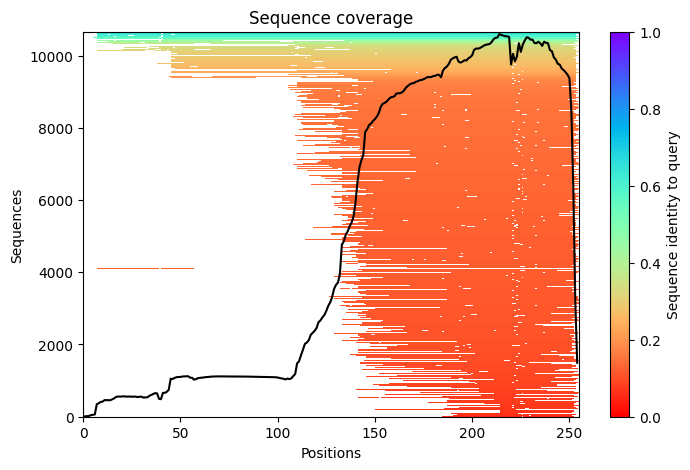

2025-04-02 21:31:23,739 Setting max_seq=512, max_extra_seq=5120
2025-04-02 21:32:45,573 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=77.4 pTM=0.546
2025-04-02 21:32:48,175 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=78.4 pTM=0.573 tol=6.25
2025-04-02 21:32:50,771 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=77.9 pTM=0.571 tol=3.44
2025-04-02 21:32:53,367 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=78.4 pTM=0.573 tol=1.32
2025-04-02 21:32:53,428 alphafold2_ptm_model_1_seed_000 took 82.8s (3 recycles)


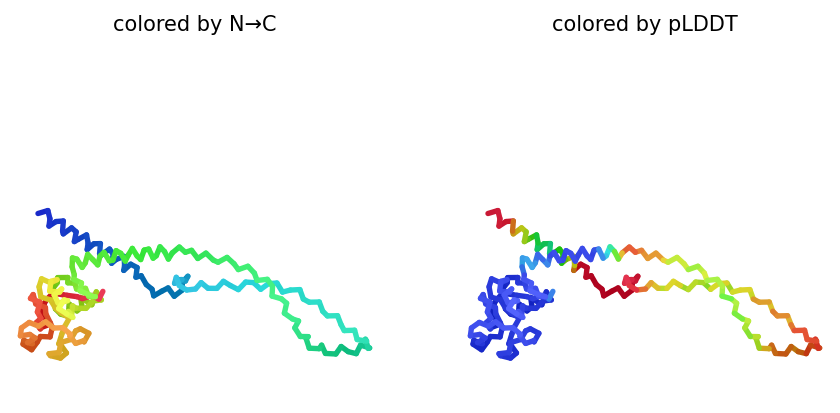

2025-04-02 21:32:56,194 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=76.6 pTM=0.521
2025-04-02 21:32:58,789 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=77.2 pTM=0.552 tol=4.46
2025-04-02 21:33:01,384 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=77.5 pTM=0.555 tol=1.26
2025-04-02 21:33:03,979 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=77.9 pTM=0.555 tol=1.15
2025-04-02 21:33:04,031 alphafold2_ptm_model_2_seed_000 took 10.4s (3 recycles)


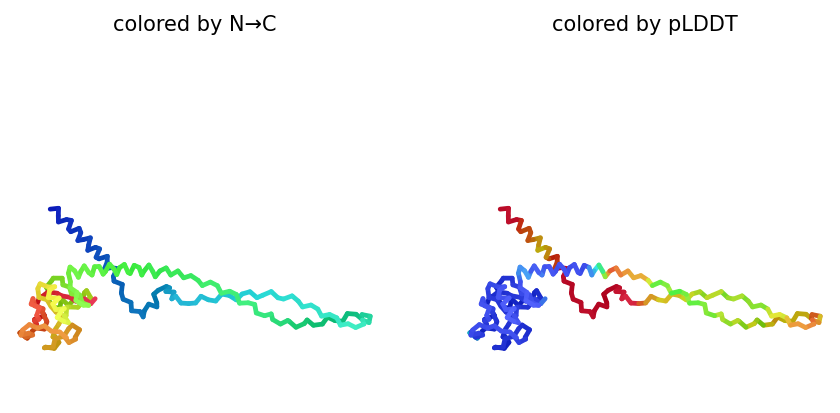

2025-04-02 21:33:06,786 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=76.6 pTM=0.507
2025-04-02 21:33:09,378 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=75.6 pTM=0.529 tol=6.21
2025-04-02 21:33:11,974 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=75.4 pTM=0.533 tol=4.86
2025-04-02 21:33:14,570 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=75.6 pTM=0.537 tol=1.71
2025-04-02 21:33:14,622 alphafold2_ptm_model_3_seed_000 took 10.4s (3 recycles)


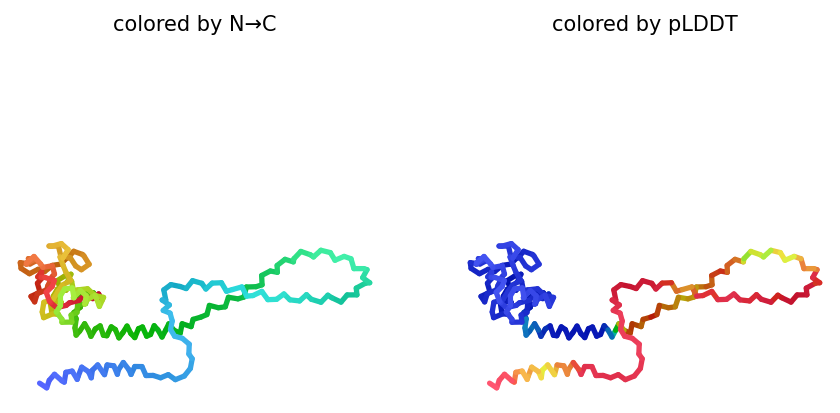

2025-04-02 21:33:17,389 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=76.2 pTM=0.544
2025-04-02 21:33:19,998 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=75.9 pTM=0.565 tol=6.39
2025-04-02 21:33:22,606 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=75.7 pTM=0.567 tol=5.19
2025-04-02 21:33:25,213 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=75.9 pTM=0.567 tol=1.68
2025-04-02 21:33:25,266 alphafold2_ptm_model_4_seed_000 took 10.4s (3 recycles)


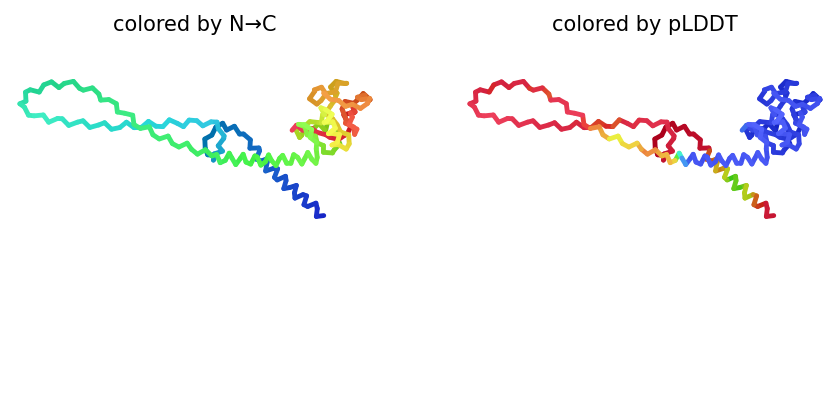

2025-04-02 21:33:28,034 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=75.2 pTM=0.547
2025-04-02 21:33:30,630 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=75.8 pTM=0.549 tol=4.36
2025-04-02 21:33:33,226 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=75.8 pTM=0.55 tol=2.64
2025-04-02 21:33:35,836 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=75.3 pTM=0.552 tol=2.15
2025-04-02 21:33:35,897 alphafold2_ptm_model_5_seed_000 took 10.4s (3 recycles)


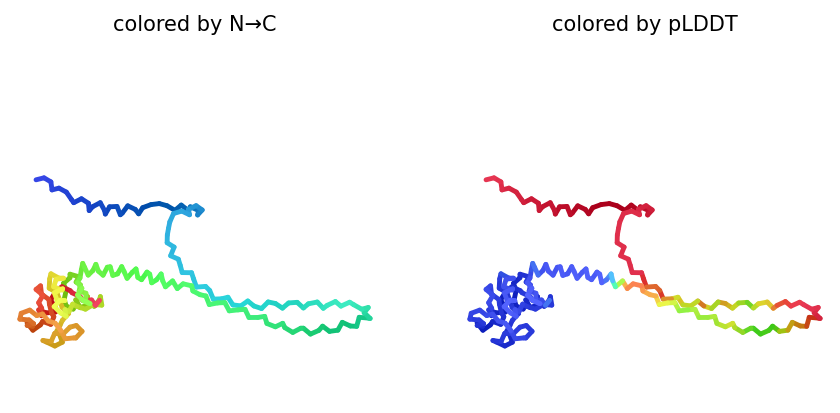

2025-04-02 21:33:36,116 reranking models by 'plddt' metric
2025-04-02 21:33:36,116 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=78.4 pTM=0.573
2025-04-02 21:33:36,117 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=77.9 pTM=0.555
2025-04-02 21:33:36,117 rank_003_alphafold2_ptm_model_4_seed_000 pLDDT=75.9 pTM=0.567
2025-04-02 21:33:36,118 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=75.6 pTM=0.537
2025-04-02 21:33:36,118 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=75.3 pTM=0.552
2025-04-02 21:33:39,824 Done
✅ Finished: MBP_macaque_66743_0


In [ ]:
#@title Run Prediction for Multiple Sequences
display_images = True #@param {type:"boolean"}

import sys
import warnings
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from Bio import BiopythonDeprecationWarning
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from colabfold.colabfold import plot_protein

# For ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

# Checking GPU status
try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
    K80_chk = "0"
if "1" in K80_chk:
    print("WARNING: found GPU Tesla K80: limited to total length < 1000")
    if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
        del os.environ["TF_FORCE_UNIFIED_MEMORY"]
    if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
        del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

# Setup logging
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed:
        if display_images:
            fig = plot_protein(protein_obj, Ls=length, dpi=150)
            plt.show()
            plt.close()

# List of sequences/jobs
sequence_tuple_list = sequences

# Loop through each sequence/job
for basejobname, query_sequence in sequence_tuple_list_modified:
    query_sequence = "".join(query_sequence.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname = basejobname + "_" + hashlib.sha1(query_sequence.encode()).hexdigest()[:5]

    # Check if directory already exists (to prevent overwriting)
    def check(folder):
        return not os.path.exists(folder)

    if not check(jobname):
        n = 0
        while not check(f"{jobname}_{n}"):
            n += 1
        jobname = f"{jobname}_{n}"

    # Make directory to save results
    os.makedirs(jobname, exist_ok=True)

    # Save the FASTA file for each sequence
    fasta_path = os.path.join(jobname, f"{jobname}.fasta")
    with open(fasta_path, "w") as f:
        f.write(f">{jobname}\n{query_sequence}")

    # Prepare queries (you might need a separate CSV or FASTA for each sequence)
    queries_path = os.path.join(jobname, f"{jobname}.csv")
    with open(queries_path, "w") as f:
        f.write(f"id,sequence\n{jobname},{query_sequence}\n")

    # Logging setup for each job
    log_filename = os.path.join(jobname, "log.txt")
    setup_logging(Path(log_filename))

    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, "auto")

    if "multimer" in model_type and max_msa is not None:
        use_cluster_profile = False
    else:
        use_cluster_profile = True

    # Download AlphaFold params and run prediction
    download_alphafold_params(model_type, Path("."))
    results = run(
        queries=queries,
        result_dir=jobname,
        use_templates=False,  # adjust if you need templates
        custom_template_path=None,  # add your template path if necessary
        num_relax=0,  # Adjust as needed
        msa_mode="mmseqs2_uniref_env",  # Adjust as needed
        model_type="auto",  # Adjust as needed
        num_models=5,  # Adjust as needed
        num_recycles=3,  # Adjust as needed
        relax_max_iterations=0,  # Adjust as needed
        recycle_early_stop_tolerance=0.5,  # Adjust as needed
        num_seeds=1,  # Adjust as needed
        use_dropout=False,  # Adjust as needed
        model_order=[1, 2, 3, 4, 5],  # Adjust if you want specific models
        is_complex=False,  # Adjust if you are working with complexes
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",  # Adjust if needed
        pair_mode="none",  # Adjust if needed
        pairing_strategy="all_vs_all",  # Adjust as needed
        stop_at_score=100,
        prediction_callback=prediction_callback,
        dpi=150,
        zip_results=True,
        save_all=True,
        max_msa = max_msa,  # Adjust as needed
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=True,
        user_agent="colabfold/google-colab-main",
        calc_extra_ptm=False,
    )

    # Create a zip of results
    results_zip = f"{jobname}.result.zip"
    os.system(f"zip -r {results_zip} {jobname}")

    print(f"✅ Finished: {jobname}")


In [72]:
from google.colab import files
files.download('/content/MBP_chimp_bd66c_0.result.zip')
files.download('/content/MBP_human_79b0c_0.result.zip')
files.download('/content/MBP_macaque_66743_0.result.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:

files.download('/content/heatmap_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>